In [1]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import pylab
from matplotlib.ticker import MaxNLocator

import seaborn as sns
from scipy.stats import skew as skew

from numba import njit, prange
from timeit import default_timer as timer

In [2]:
dt = .001
tau = .1
noise_tau = .002
w11, w22 = 1, 1
w21, w12 = 1, 1
dur = 10
sgm = 10
threshold = 70
S = 576
R_initial = 32
eta = S*.1

In [3]:
@njit(parallel=True, fastmath=True)
def ratio_choice(coh, a, b):

    alpha = a
    beta = b

    #S = (w11+w12-beta) * R_initial**2 + (1-alpha) * R_initial
    V1 = S*(1+coh)
    V2 = S*(1-coh)

    R1_arr = np.zeros(int(dur/dt))
    R2_arr = np.zeros(int(dur/dt))
    R1_arr[0], R2_arr[0] = R_initial, R_initial
    # R1_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w11+w12-beta))) / (2*(w11+w12-beta))
    # R2_arr[0] = ((alpha-1) + np.sqrt((1-alpha)**2 + 4*S*(w22+w21-beta))) / (2*(w22+w21-beta))

    G1_arr = np.zeros(int(dur/dt))
    G2_arr = np.zeros(int(dur/dt))
    G1_arr[0], G2_arr[0] = (w11+w12)*R1_arr[0], (w22+w21)*R2_arr[0]

    D1_arr = np.zeros(int(dur/dt))
    D2_arr = np.zeros(int(dur/dt))
    D1_arr[0], D2_arr[0] = 0, 0

    noise_R1 = np.zeros(int(dur/dt))
    noise_R2 = np.zeros(int(dur/dt))
    noise_G1 = np.zeros(int(dur/dt))
    noise_G2 = np.zeros(int(dur/dt))
    noise_D1 = np.zeros(int(dur/dt))
    noise_D2 = np.zeros(int(dur/dt))

    reaction_time = np.zeros(10240)
    choice = np.zeros(10240)

    for i in prange(10240):

        for ti in range(1, int(dur/dt)):

            if ti % 5 == 0:
                    V1 = S*(1+coh) + np.random.randn() * eta
                    V2 = S*(1-coh) + np.random.randn() * eta

            d_noiseR1 = (-noise_R1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseR2 = (-noise_R2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG1 = (-noise_G1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseG2 = (-noise_G2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD1 = (-noise_D1[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt
            d_noiseD2 = (-noise_D2[ti-1] + np.random.randn() * np.sqrt(dt) * sgm) / noise_tau*dt

            d_R1 = (-R1_arr[ti-1] + (alpha * R1_arr[ti-1] + V1) / (1 + G1_arr[ti-1])) * dt/tau
            d_R2 = (-R2_arr[ti-1] + (alpha * R2_arr[ti-1] + V2) / (1 + G2_arr[ti-1])) * dt/tau
            d_G1 = (-G1_arr[ti-1] + w11*R1_arr[ti-1] + w12*R2_arr[ti-1] - D1_arr[ti-1]) * dt/tau
            d_G2 = (-G2_arr[ti-1] + w21*R1_arr[ti-1] + w22*R2_arr[ti-1] - D2_arr[ti-1]) * dt/tau
            d_D1 = (-D1_arr[ti-1] + beta*R1_arr[ti-1]) *dt/tau
            d_D2 = (-D2_arr[ti-1] + beta*R2_arr[ti-1]) *dt/tau

            noise_R1[ti] = noise_R1[ti-1] + d_noiseR1
            noise_R2[ti] = noise_R2[ti-1] + d_noiseR2
            noise_G1[ti] = noise_G1[ti-1] + d_noiseG1
            noise_G2[ti] = noise_G2[ti-1] + d_noiseG2
            noise_D1[ti] = noise_D1[ti-1] + d_noiseD1
            noise_D2[ti] = noise_D2[ti-1] + d_noiseD2

            R1_arr[ti] = max(R1_arr[ti-1] + d_R1 + noise_R1[ti], 0)
            R2_arr[ti] = max(R2_arr[ti-1] + d_R2 + noise_R2[ti], 0)
            G1_arr[ti] = max(G1_arr[ti-1] + d_G1 + noise_G1[ti], 0)
            G2_arr[ti] = max(G2_arr[ti-1] + d_G2 + noise_G2[ti], 0)
            D1_arr[ti] = max(D1_arr[ti-1] + d_D1 + noise_D1[ti], 0)
            D2_arr[ti] = max(D2_arr[ti-1] + d_D2 + noise_D2[ti], 0)

            if R1_arr[ti] > threshold:
                choice[i] = 1
                reaction_time[i] = ti
                break
            elif R2_arr[ti] > threshold:
                reaction_time[i] = ti
                break
            elif ti == dur/dt-1:
                reaction_time[i] = np.NAN
                choice[i] = np.NAN

    return reaction_time, choice

In [4]:
@njit(parallel=True)
def heatmap_array():
    alpha_arr, beta_arr = np.arange(0.5, 80, .5), np.arange(0.1, 2.5, .01)
    #alpha_arr, beta_arr = np.arange(0.5, 80, 5), np.arange(0.1, 2.5, 0.1)
    RT_arr, choice_arr = np.zeros((len(beta_arr), len(alpha_arr), 10240)), np.zeros((len(beta_arr), len(alpha_arr), 10240))

    for column in prange(len(alpha_arr)):
        for row in prange(len(beta_arr)):

            alpha = alpha_arr[column]
            beta = beta_arr[row]
            coh = .18
            RT_arr[row, column, :], choice_arr[row, column, :] = ratio_choice(coh, alpha, beta)

    return RT_arr, choice_arr

In [5]:
def heatmap_val(RT, choice):
    alpha_arr, beta_arr = np.arange(.5, 80, .5), np.arange(.1, 2.5, .01)
    #alpha_arr, beta_arr = np.arange(0.5, 80, 5), np.arange(0.1, 2.5, 0.1)
    RT_skew, RT_mean = np.zeros((len(beta_arr), len(alpha_arr))), np.zeros((len(beta_arr), len(alpha_arr)))
    RT_std, choice_acc = np.zeros((len(beta_arr), len(alpha_arr))), np.zeros((len(beta_arr), len(alpha_arr)))

    for column in range(len(alpha_arr)):
        for row in range(len(beta_arr)):
            curr_reaction, curr_choice = RT[row, column, :], choice[row, column, :]
            RT_skew[row, column], RT_mean[row, column], RT_std[row, column] = skew(curr_reaction, nan_policy='omit'), np.nanmean(curr_reaction), np.nanstd(curr_reaction)
            choice_acc[row, column] = np.nanmean(curr_choice)

    return RT_skew, RT_mean, RT_std, choice_acc

In [8]:
s = timer()
RT_arr, choice_arr = heatmap_array()
np.save('ratio2/choice_arr_eta04', choice_arr)
np.save('ratio2/RT_arr_eta04', RT_arr)
t = timer() - s
print(t)

FileNotFoundError: [Errno 2] No such file or directory: 'ratio2/choice_arr_eta04.npy'

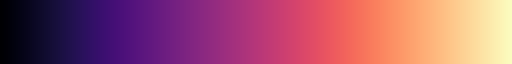

In [47]:
sns.color_palette("magma", as_cmap=True)

In [104]:
def get_heatmap(RT_skew, RT_mean, RT_std, choice_acc, cp):
    alpha_arr, beta_arr = np.arange(.5, 80, .5), np.arange(.1, 2.5, .01)
    mask = np.empty((len(beta_arr), len(alpha_arr)))
    mask.fill(np.nan)
    color_palette = cp
    fig, axes = plt.subplots(2, 2, figsize=(25, 20))
    skew_ax = sns.heatmap(RT_skew, ax=axes[0, 0], cmap=color_palette)#, mask=np.ma.masked_invalid(RT_skew))
    skew_ax.set_title("Skewness")
    mean_ax = sns.heatmap(RT_mean, ax=axes[0, 1], cmap=color_palette)#, mask=np.ma.masked_invalid(RT_mean))
    mean_ax.set_title("Mean")
    std_ax = sns.heatmap(RT_std, ax=axes[1, 0], cmap=color_palette)#, mask=np.ma.masked_invalid(RT_std))
    std_ax.set_title("STD")
    choice_ax = sns.heatmap(choice_acc, ax=axes[1,1], cmap=color_palette)#, mask=np.ma.masked_invalid(choice_acc))
    choice_ax.set_title("Choice Accuracy")

    for ax in axes.flat:
        ax.set_xlabel("α")
        ax.set_ylabel("β")

        ax.xaxis.set_ticks(np.linspace(0, 156, num=10))
        ax.xaxis.set_ticklabels(np.round(np.linspace(.5, 80, num=10), 1), rotation=0)
        ax.yaxis.set_ticks(np.linspace(0, 239, num=10))
        ax.yaxis.set_ticklabels(np.round(np.linspace(0.1, 2.5, num=10), 1))
        ax.invert_yaxis()

        font_size = 30
        params = {
                 'legend.fontsize': font_size,
                 'axes.labelsize': font_size,
                 'axes.titlesize': font_size,
                 'xtick.labelsize': font_size,
                 'ytick.labelsize': font_size}
        pylab.rcParams.update(params)


    plt.tight_layout()
    plt.savefig("heatmap.tiff", format="tiff")
    #plt.show()

C:\Users\weiyi\AppData\Local\Temp\ipykernel_27176\3599052614.py:10: RuntimeWarning: Mean of empty slice
  RT_skew[row, column], RT_mean[row, column], RT_std[row, column] = skew(curr_reaction, nan_policy='omit'), np.nanmean(curr_reaction), np.nanstd(curr_reaction)
C:\Users\weiyi\AppData\Local\Temp\ipykernel_27176\3599052614.py:10: UserWarning: Warning: converting a masked element to nan.
  RT_skew[row, column], RT_mean[row, column], RT_std[row, column] = skew(curr_reaction, nan_policy='omit'), np.nanmean(curr_reaction), np.nanstd(curr_reaction)
C:\Users\weiyi\AppData\Local\Temp\ipykernel_27176\3599052614.py:11: RuntimeWarning: Mean of empty slice
  choice_acc[row, column] = np.nanmean(curr_choice)


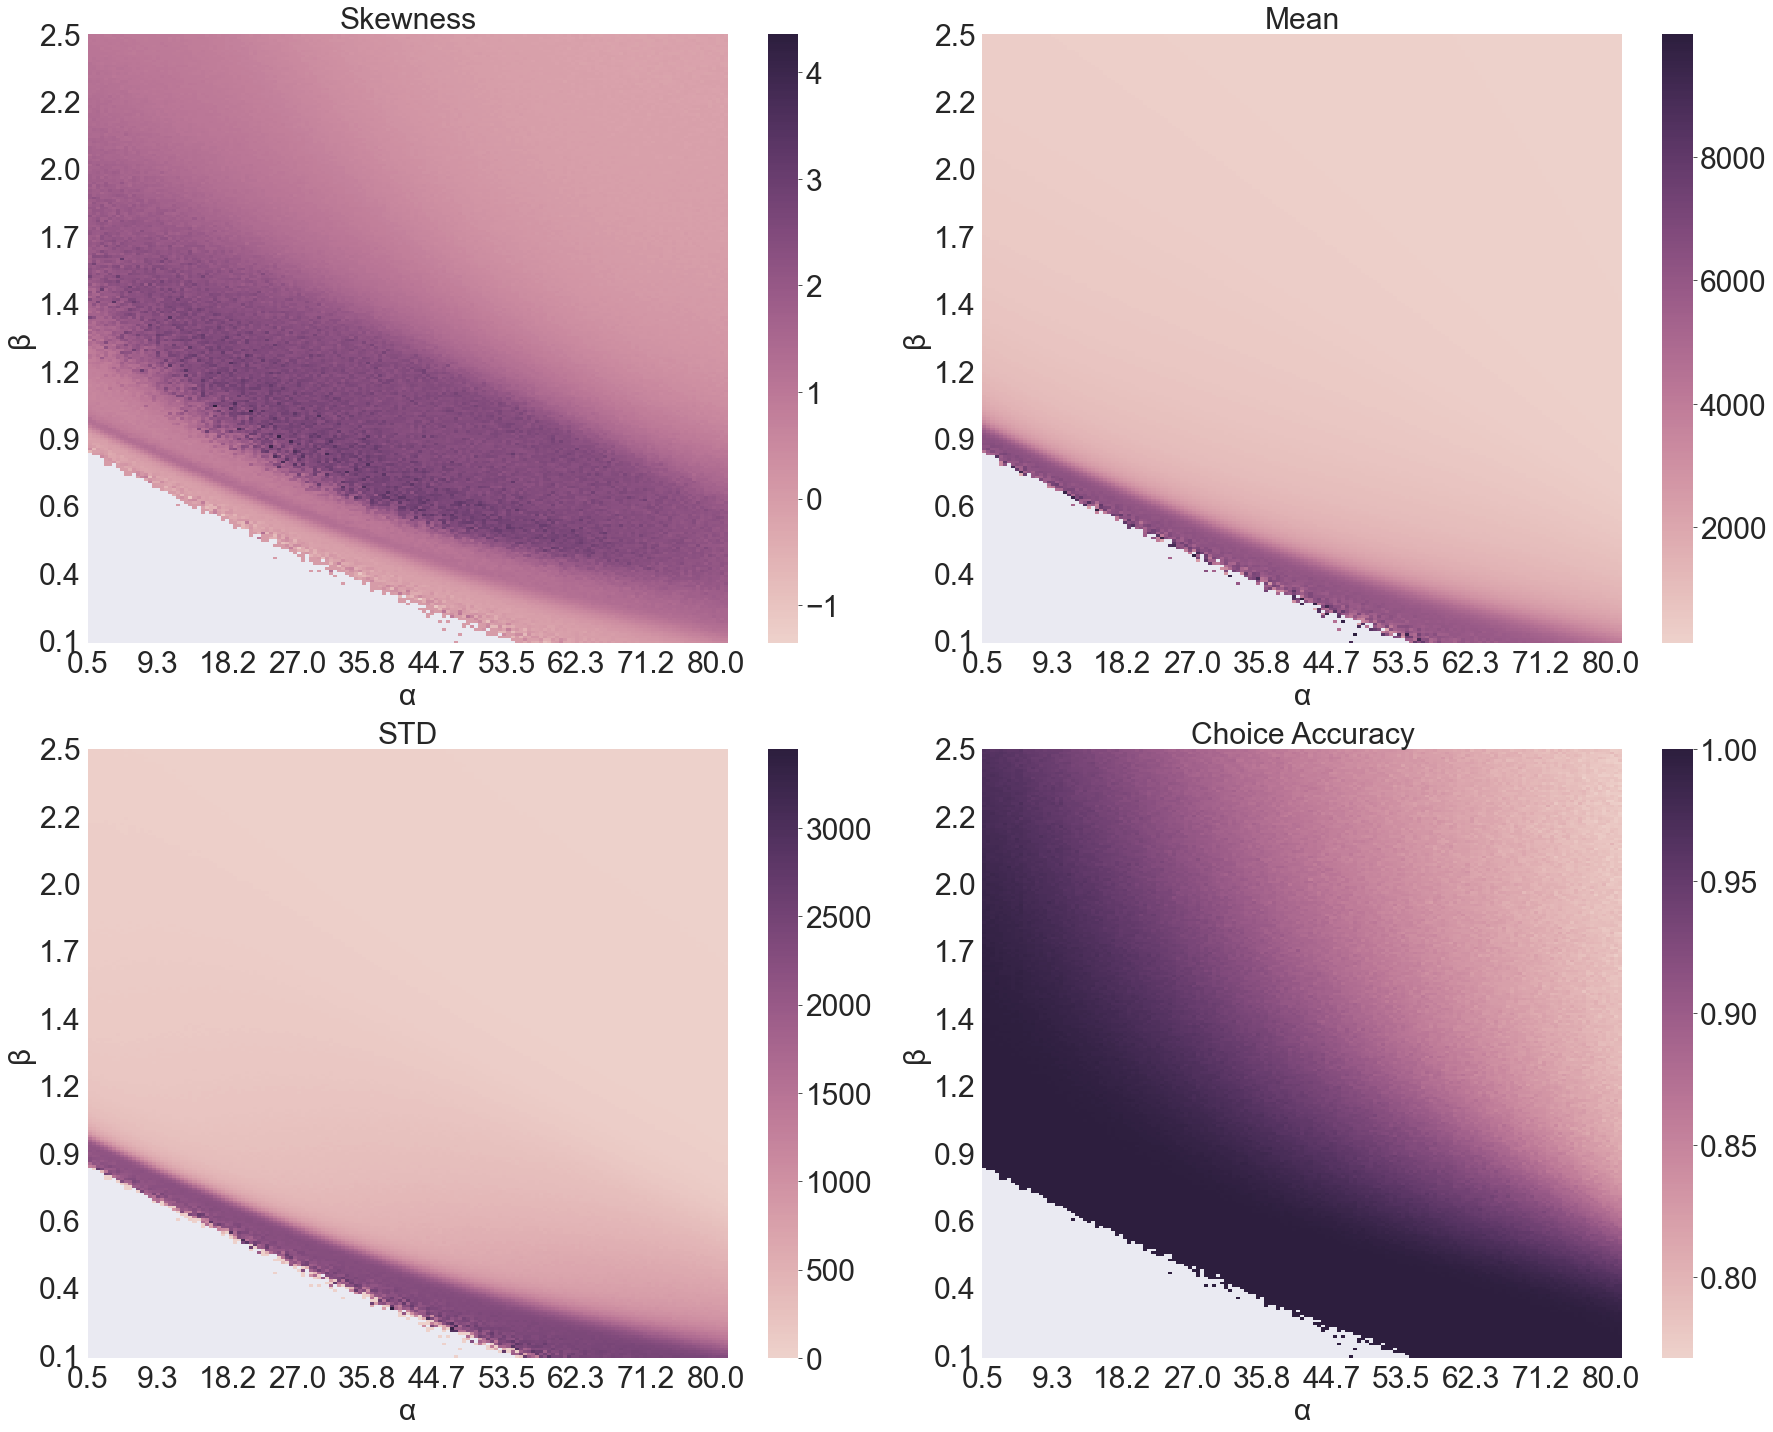

In [106]:
RT_skew, RT_mean, RT_std, choice_acc = heatmap_val(RT_arr, choice_arr)
get_heatmap(RT_skew, RT_mean, RT_std, choice_acc, sns.cubehelix_palette(as_cmap=True))

In [96]:
np.save('choice_arr_eta04', choice_arr)
np.save('RT_arr_eta04', RT_arr)

In [ ]:
@njit(parallel=True)
def trial_array(RT_arr):
    alpha_arr, beta_arr = np.arange(0.5, 80, .5), np.arange(0.1, 2.5, .01)
    trial_arr = np.zeros((len(beta_arr), len(alpha_arr)))

    for column in prange(len(alpha_arr)):
        for row in prange(len(beta_arr)):
            trial_arr[row, column] = sum(~np.isnan(RT_arr[row, column, :]))

    return trial_arr

def trial_graph(trial_arr):

    alpha_arr, beta_arr = np.arange(0.5, 80, .5), np.arange(0.1, 2.5, .01)


    ax = sns.heatmap(trial_arr)
    ax.set_xlabel("alpha", fontsize=12)
    ax.set_ylabel("beta", fontsize=12)

    x_tick_labels = alpha_arr[::int(len(alpha_arr) / 15)]
    ax.xaxis.set_major_locator(MaxNLocator(len(x_tick_labels)))
    ax.set_xticklabels(x_tick_labels, rotation=45)

    y_tick_labels = beta_arr[::int(len(beta_arr) / 9)]
    ax.yaxis.set_major_locator(MaxNLocator(len(y_tick_labels)))
    ax.set_yticklabels([i.round(2) for i in y_tick_labels])
    ax.invert_yaxis()

    plt.title("Trials Making Decisions")
    plt.tight_layout()
    plt.show()

trial_graph(trial_array(RT_arr))

In [52]:
@njit(parallel=True)
def mask_array(RT_arr, choice_arr):
    alpha_arr, beta_arr = np.arange(0.5, 80, .5), np.arange(0.1, 2.5, .01)
    mask_RT, mask_choice = np.zeros((len(beta_arr), len(alpha_arr), 10240)), np.zeros((len(beta_arr), len(alpha_arr), 10240))

    for column in prange(len(alpha_arr)):
        for row in prange(len(beta_arr)):
            if sum(np.isnan(RT_arr[row, column, :])) > 103:
            #if np.count_nonzero(RT_arr[row, column, :]) < 10000:
                mask_RT[row, column, :], mask_choice[row, column, :] = np.zeros(10240), np.zeros(10240)
            else:
                mask_RT[row, column, :], mask_choice[row, column, :] = RT_arr[row, column, :], choice_arr[row, column, :]

    return mask_RT, mask_choice

In [59]:
mask_RT, mask_choice = mask_array(RT_arr, choice_arr)
mask_RT_skew, mask_RT_mean, mask_RT_std, mask_choice_acc = heatmap_val(mask_RT, mask_choice)

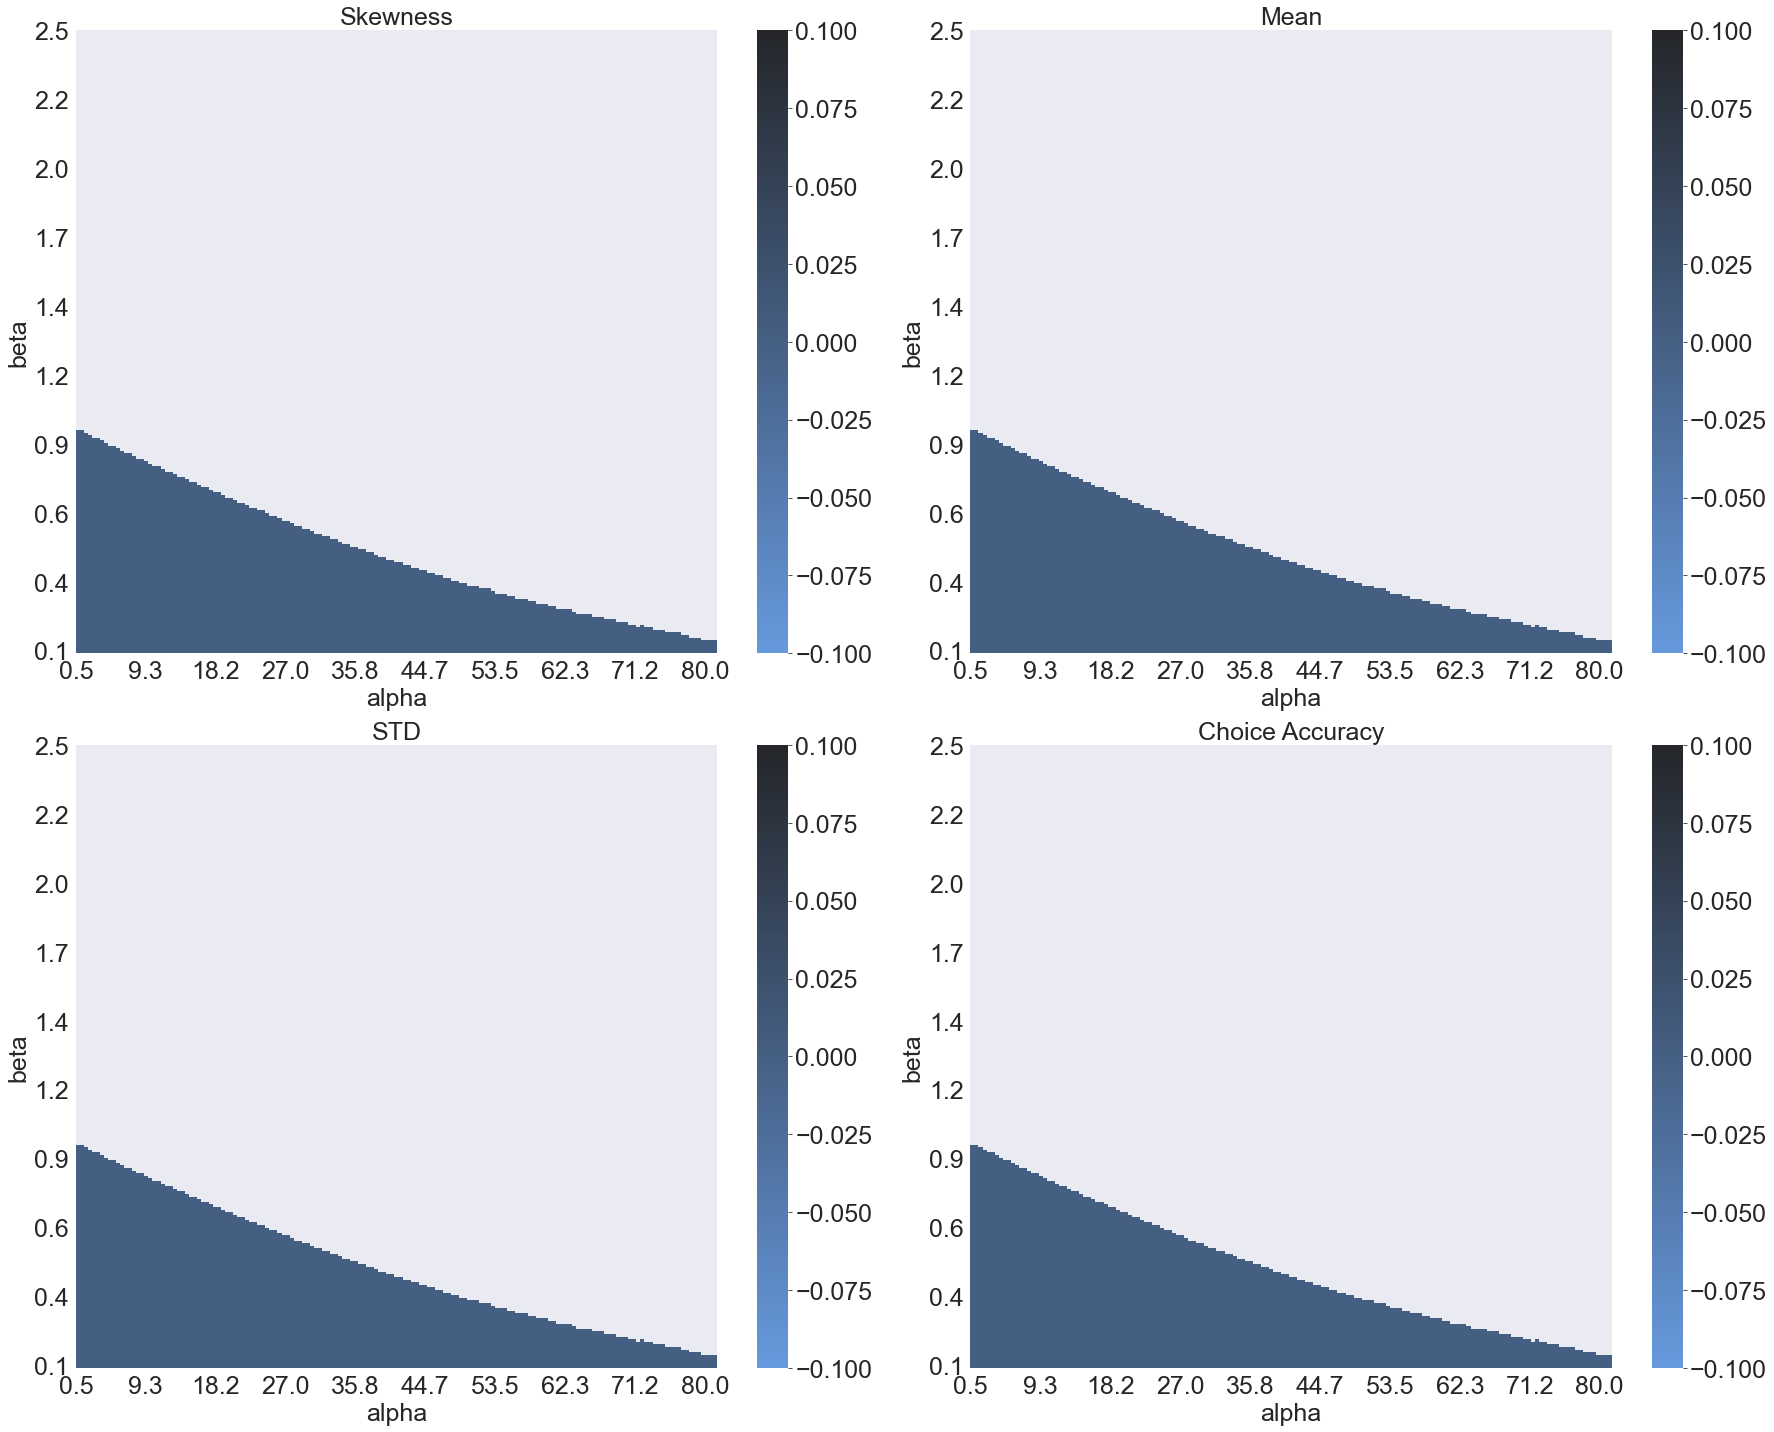

In [85]:
get_heatmap(mask_RT_skew, mask_RT_mean, mask_RT_std, mask_choice_acc, sns.dark_palette("#69d", reverse=True, as_cmap=True))

C:\Users\weiyi\AppData\Local\Temp\ipykernel_20476\1952061207.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_heatmap" failed type inference due to: Untyped global name 'MaxNLocator': Cannot determine Numba type of <class 'type'>

File "..\AppData\Local\Temp\ipykernel_20476\1952061207.py", line 20:
<source missing, REPL/exec in use?>

  @jit
C:\Users\weiyi\AppData\Local\Temp\ipykernel_20476\1952061207.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_heatmap" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "..\AppData\Local\Temp\ipykernel_20476\1952061207.py", line 15:
<source missing, REPL/exec in use?>

  @jit
C:\Users\weiyi\anaconda3\envs\LDDM\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "get_heatmap" was compiled in object mode without forceobj=True, but has lifte

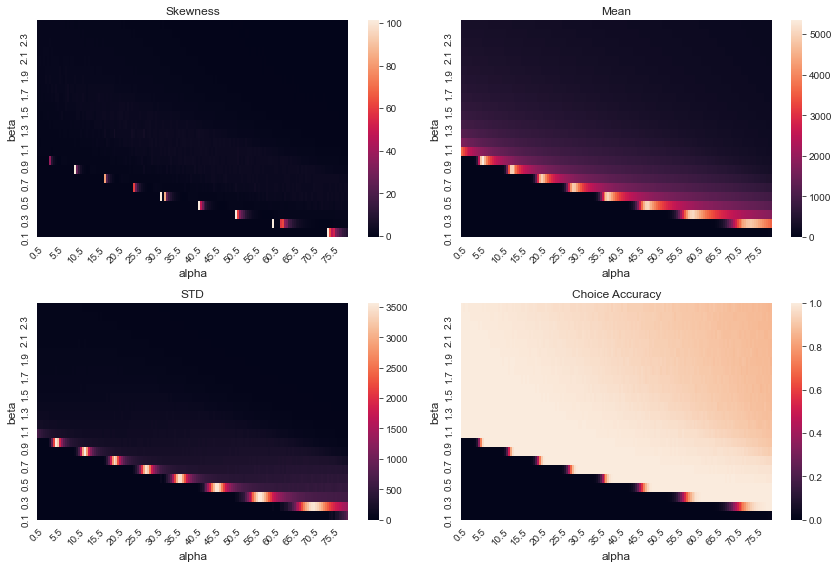

In [7]:
RT_arr, choice_arr = heatmap_array()
RT_skew, RT_mean, RT_std, choice_acc = heatmap_val(RT_arr, choice_arr)
get_heatmap(RT_skew, RT_mean, RT_std, choice_acc)

In [8]:
plt.savefig("heatmap1.png")

<Figure size 432x288 with 0 Axes>